In [98]:
# import desired libraries
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

custom = {"axes.edgecolor": "red", "grid.linestyle": "dashed", "grid.color": "black"}
sns.set_style("darkgrid", rc=custom)

# tokenizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# train a NN
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from tensorflow.keras.layers import (
Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, 
GlobalMaxPooling1D, Concatenate, SpatialDropout1D
)
from tensorflow.keras.models import Model

# split train test datasets
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

# feature scaling
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter("ignore")

In [62]:
# load datasets
train_df = pd.read_csv("/kaggle/input/cse-291-dsc-253-data-mining-challenge/train.csv")
test_df = pd.read_csv("/kaggle/input/cse-291-dsc-253-data-mining-challenge/test.csv")

In [63]:
# print num feats and datapoints
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (13144, 62)
Test shape :  (10000, 61)


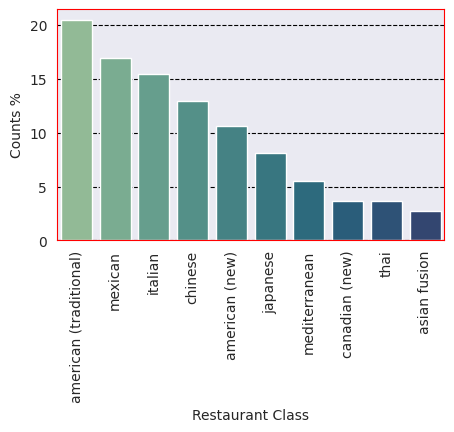

In [64]:
# check the cardinality of target distribution
rs_target = train_df['label'].value_counts(normalize=True) * 100

# target imbalance?
plt.figure(figsize=(5, 3))
sns.barplot(x=rs_target.index, y=rs_target.values, palette='crest')
plt.xlabel('Restaurant Class')
plt.xticks(rotation=90)
plt.ylabel('Counts %')
plt.show()

In [65]:
# check data-types and non-null counts of the features
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13144 entries, 0 to 13143
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     13144 non-null  int64  
 1   attributes.HappyHour                   1256 non-null   object 
 2   attributes.Ambience                    11338 non-null  object 
 3   hours.Tuesday                          10412 non-null  object 
 4   postal_code                            13144 non-null  object 
 5   attributes.AgesAllowed                 12 non-null     object 
 6   attributes.GoodForDancing              1111 non-null   object 
 7   attributes.OutdoorSeating              11845 non-null  object 
 8   hours.Saturday                         10525 non-null  object 
 9   attributes.Corkage                     182 non-null    object 
 10  longitude                              13144 non-null  float64
 11  na

In [66]:
# check missing values
train_df[['label', 'review']].isna().sum()

label     0
review    0
dtype: int64

In [67]:
# check a sample review
idx = 90
print(train_df["label"][idx], '\n')
print(train_df["review"][idx])

italian 

Great place around the corner from us. We drive by this place all the time and finally decided to go in. Pizzas were tasty and made on the spot and quickly. Will definitely be coming back. This place has a really nice modern aesthetic. I got the Pesto Toscano pizza and it was pretty good. The pizza crust is thick yet airy, with just the right amount of crunch on the exterior. The pizza would have been 5 stars if it weren't for the olives they used. I usually like olives but these olives were wayyyy too strong for the pizza. They overpowered all other flavors and that was disappointing because it was a great pizza otherwise. I would probably spring for the Margherita next time. I swung by Levetto tonight to check it out, since it\'s new to our neighbourhood. I had  the Funghi Pizza, which was delicious and an amazing value at 7$ for a "personal" size- a generous portion for one person. The toppings were super fresh and as I am a bit of a stickler for pizza crust, was happy to 

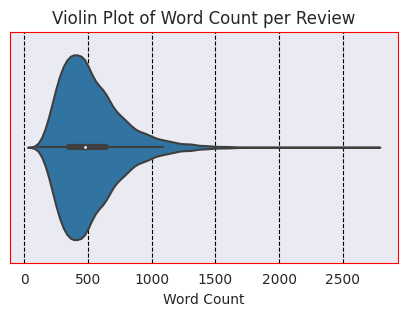

(525.5101947656725, 247.29966818641543)

In [68]:
# check review length distribution
lens = [len(review.split()) for review in train_df.review]

# calculate the statistics
plt.figure(figsize=(5,3))
sns.violinplot(x=lens)
plt.title('Violin Plot of Word Count per Review')
plt.xlabel('Word Count')
plt.show()

np.mean(lens), np.std(lens)

In [69]:
# non-null columns
non_null_columns = ["longitude", "latitude", "review_count", "stars", "state"]
train_df[non_null_columns].head()

,longitude,latitude,review_count,stars,state
0,-81.820568,41.484197,70,4.0,b'OH'
1,-112.032893,33.379283,181,3.5,b'AZ'
2,-79.339163,43.669144,6,3.0,b'ON'
3,-115.242714,36.159527,6,4.0,b'NV'
4,-81.726357,41.330546,33,3.5,b'OH'


In [70]:
# check the variation of review counts
train_df.groupby('label')['review_count'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
american (new),1399.0,155.803431,345.157022,5.0,18.0,54.0,155.00,5763.0
american (traditional),2680.0,91.842910,194.217113,5.0,15.0,37.0,95.25,3300.0
asian fusion,362.0,88.861878,181.192824,5.0,13.0,38.5,90.75,2174.0
canadian (new),484.0,39.962810,63.607188,5.0,10.0,20.0,43.00,711.0
chinese,1696.0,53.548349,95.396487,5.0,11.0,24.0,60.00,1791.0
italian,2032.0,80.494587,135.390047,5.0,12.0,31.0,85.25,1461.0
japanese,1063.0,103.641580,173.190936,5.0,14.5,45.0,113.00,1912.0
mediterranean,728.0,74.407967,113.566091,5.0,12.0,29.0,80.00,832.0
mexican,2217.0,84.276951,151.022137,5.0,14.0,34.0,85.00,1624.0


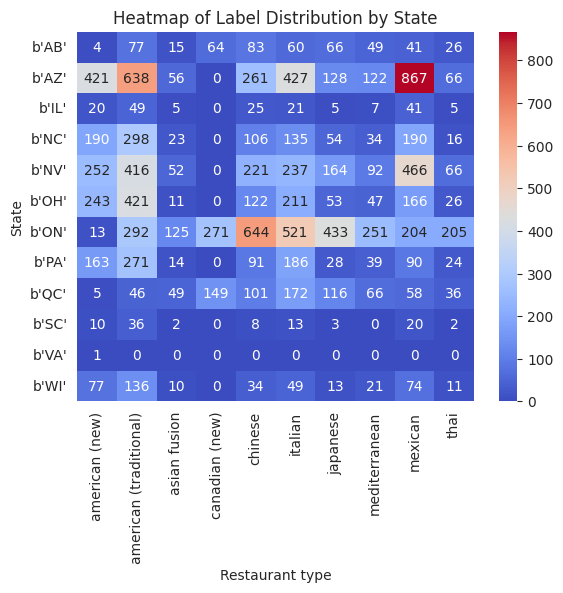

In [71]:
# check state wise distribution
heatmap_data = pd.crosstab(train_df['state'], train_df['label'])
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d')
plt.title("Heatmap of Label Distribution by State")
plt.xlabel("Restaurant type")
plt.ylabel("State")
plt.show()

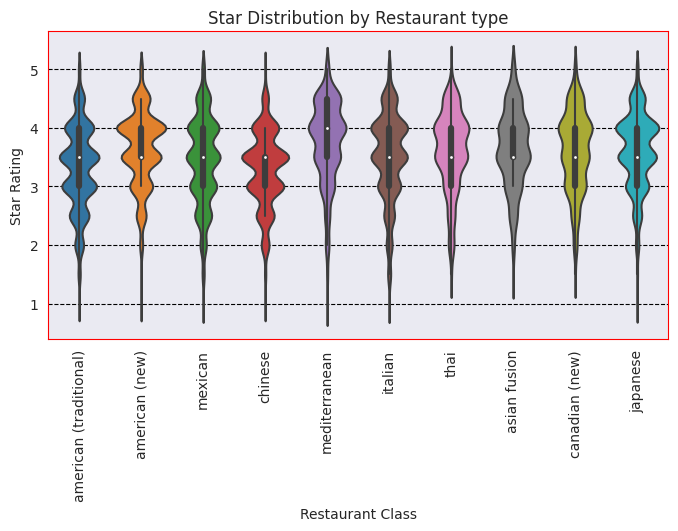

In [72]:
# check star distribution across restaurant types
plt.figure(figsize=(8, 4))
sns.violinplot(x='label', y='stars', data=train_df)
plt.title('Star Distribution by Restaurant type')
plt.xlabel('Restaurant Class')
plt.ylabel('Star Rating')
plt.xticks(rotation=90)
plt.show()

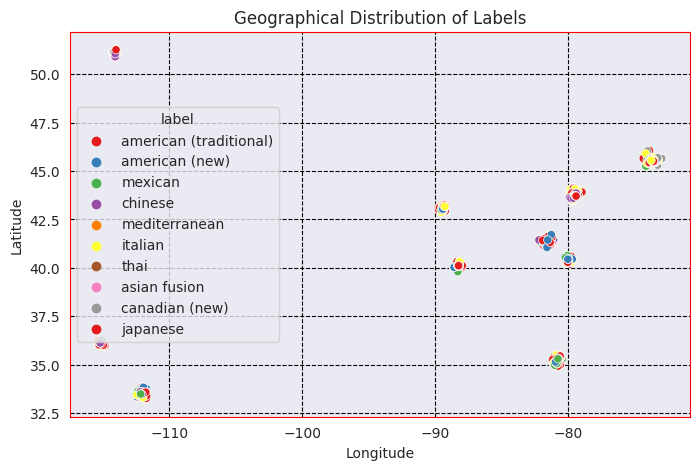

In [73]:
# check lat-long across restaurant types
plt.figure(figsize=(8, 5))
sns.scatterplot(data=train_df, x='longitude', y='latitude', hue='label', palette='Set1')
plt.title("Geographical Distribution of Labels")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

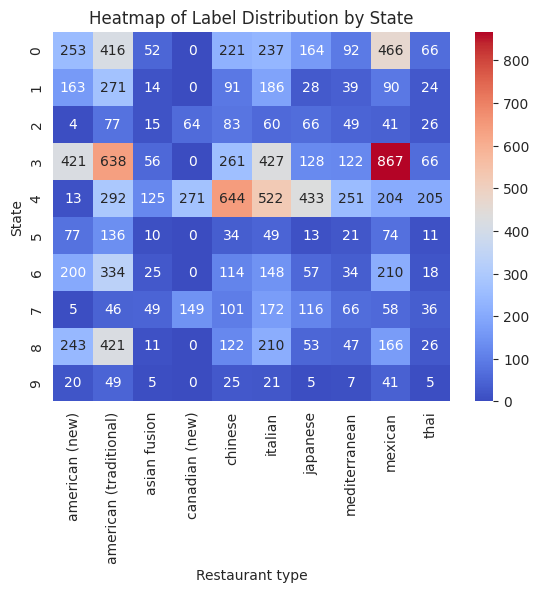

In [74]:
from sklearn.cluster import KMeans

# combine lat, lon into a 2D array
locations = train_df[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=10)  # 10 clusters as an example
train_df['location_cluster'] = kmeans.fit_predict(locations)
test_df['location_cluster'] = kmeans.fit_predict(test_df[['latitude', 'longitude']].values)

# check state wise distribution
heatmap_data = pd.crosstab(train_df['location_cluster'], train_df['label'])
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d')
plt.title("Heatmap of Label Distribution by State")
plt.xlabel("Restaurant type")
plt.ylabel("State")
plt.show()

In [75]:
# convert categorical to int
train_df['state'] = train_df['state'].astype('category')
category_mapping = dict(enumerate(train_df['state'].cat.categories))

train_df['state'] = train_df['state'].cat.codes

# apply the same encoding to the test data
test_df['state'] = test_df['state'].astype('category')

# Set test set categories to match train set categories
reversed_category_mapping_dict = {v: k for k, v in category_mapping.items()}

# Map using the reversed dictionary
test_df['state'] = test_df['state'].map(reversed_category_mapping_dict)
test_df['state'] = test_df['state'].fillna(len(reversed_category_mapping_dict)+1)

# Display the category to integer mapping
print("Category to Integer Mapping:", category_mapping)

Category to Integer Mapping: {0: "b'AB'", 1: "b'AZ'", 2: "b'IL'", 3: "b'NC'", 4: "b'NV'", 5: "b'OH'", 6: "b'ON'", 7: "b'PA'", 8: "b'QC'", 9: "b'SC'", 10: "b'VA'", 11: "b'WI'"}


In [76]:
# use only the relevant columns
relevant_cols = ['id', 'state', 'location_cluster', 'stars', 'review_count', 'review', 'label']

train_df = train_df[[col for col in relevant_cols if col in train_df.columns]]
test_df = test_df[[col for col in relevant_cols if col in test_df.columns]]

In [77]:
from sklearn.preprocessing import MinMaxScaler

# Feature Normalisation
scaler = MinMaxScaler()
trns_cols = ['state', 'location_cluster', 'stars', 'review_count']
train_df[trns_cols] = scaler.fit_transform(train_df[trns_cols])
test_df[trns_cols] = scaler.transform(test_df[trns_cols])

In [82]:
# preprocessing
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

def clean_text(x, tokenise=False):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’' + '[\{\}\[\]\(\)]':
        x = x.replace(punct, '')

    tokens = x.lower().split(" ")
    tokens = [word for word in tokens if word not in stop and 20>len(word)>1]

    if tokenise:
        return tokens
    
    return " ".join(tokens)

In [83]:
# using word2vec embeddings
import gensim
from gensim.models import Word2Vec

# curate input data for training the Word2Vec model, list of sentences
sentences = list(train_df["review"].apply(lambda x: clean_text(x, tokenise=True)))

embed_size = 300 # how big is each word vector

# this will be a shallow deep learning model
wv_model = Word2Vec(
    sentences=sentences,
    min_count=2, # ignores all words with a total frequency lower than this value.
    window=10, # model will consider the n words before and n words after that word as part of the context.
    negative=7, # k = the number of negative samples to use
    sg=0, # use CBOW model.
    vector_size=embed_size,
    sample=1e-3, # downsample setting for frequent words
    workers=10
)

In [84]:
# build vocab
wv_model.build_vocab(sentences, progress_per=10000)
print(wv_model.corpus_count)
print("Vocabulary Length:", len(wv_model.wv.key_to_index))

13144
Vocabulary Length: 40672


In [85]:
# apply preprocessing
train_df["review"] = train_df["review"].apply(lambda x: clean_text(x))
test_df["review"] = test_df["review"].apply(lambda x: clean_text(x))

train_data = train_df.copy()

In [87]:
train_data.head(5)

,id,state,location_cluster,stars,review_count,review,label
0,0,0.454545,0.888889,0.750,0.011289,stopped way side quest street nnwe know expect...,american (traditional)
1,1,0.090909,0.333333,0.625,0.030566,go healthy spot food always fresh delicious se...,american (new)
2,2,0.545455,0.444444,0.500,0.000174,food court meal gerrard square since nachos ho...,mexican
3,3,0.363636,0.000000,0.750,0.000174,located rainbow charleston small family owned ...,mexican
4,4,0.454545,0.888889,0.625,0.004863,frills chinese takeout joint serves best area ...,chinese


In [94]:
## split to train and val
train_df, val_df = train_test_split(train_data, test_size=0.1, random_state=2026)

# a separte dataframe for trns_cols
train_other = train_df[trns_cols].values
val_other = val_df[trns_cols].values
test_other = test_df[trns_cols].values

## some config values 
max_features = len(wv_model.wv.key_to_index) # how many unique words to use (i.e num rows in embedding vector)
maxlen = 700 # max number of words in a review to use

## fill up the missing values
train_X = train_df["review"].values
val_X = val_df["review"].values
test_X = test_df["review"].values

## tokenize the sentences
# Tokenizer learns a word-to-integer index mapping based on the frequency of words in the training text.
tokenizer = Tokenizer(num_words=max_features, oov_token="<oov>")
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## pad the sentences
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

print(train_X.shape)
print(test_X.shape)

(11829, 700)
(10000, 700)


In [91]:
# get word index (mapping from word to integer index)
word_index = tokenizer.word_index

# curating embedding matrix
# embedding_matrix = np.zeros((max_features, embed_size))
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))

# populate the embedding matrix with Word2Vec vectors
for word, i in word_index.items():
    if word in wv_model.wv:
        embedding_matrix[i] = wv_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embed_size,))
        
# check the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (103723, 300)


In [92]:
# encode class values as integers
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_df['label'])

# Transform and one-hot encode training labels
encoded_train_y = encoder.transform(train_df['label'])
train_y = tf.keras.utils.to_categorical(encoded_train_y, num_classes=10)

# Transform and one-hot encode validation labels
encoded_val_y = encoder.transform(val_df['label'])
val_y = tf.keras.utils.to_categorical(encoded_val_y, num_classes=10)

In [93]:
# ChatGPT
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)  # Round predictions to either 0 or 1
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)  # True positives
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)  # False positives
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)  # False negatives

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())  # F1 score

    return K.mean(f1)  # Return the mean F1 score across classes

In [95]:
trns_cols

['state', 'location_cluster', 'stars', 'review_count']

In [101]:
# train a NN
# Input layer for text data
text_input = Input(shape=(maxlen,), name='text_input')
x = Embedding(
    len(word_index)+1, 
    embed_size, 
    weights=[embedding_matrix],
    trainable=False
)(text_input)
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)

# Input layer for additional features
other_input = Input(shape=(len(trns_cols),), name='other_input')
y = Dense(16, activation='relu')(other_input)
y = Dropout(0.1)(y)
y = Dense(8, activation='relu')(y)

# Concatenate the text and additional features
combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.25)(z)
z = Dense(10, activation="softmax")(z)

# Create the model
model = Model(inputs=[text_input, other_input], outputs=z)
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy', f1_score]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 700)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 700, 300)  │ 31,116,900 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_input         │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 700, 256)  │    330,240 │ embedding_3[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │         80 │ other_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 700, 256)  │    296,448 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional_5[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │        136 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 264)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │     16,960 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10)        │        650 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,761,414 (121.16 MB)

 Trainable params: 644,514 (2.46 MB)

 Non-trainable params: 31,116,900 (118.70 MB)

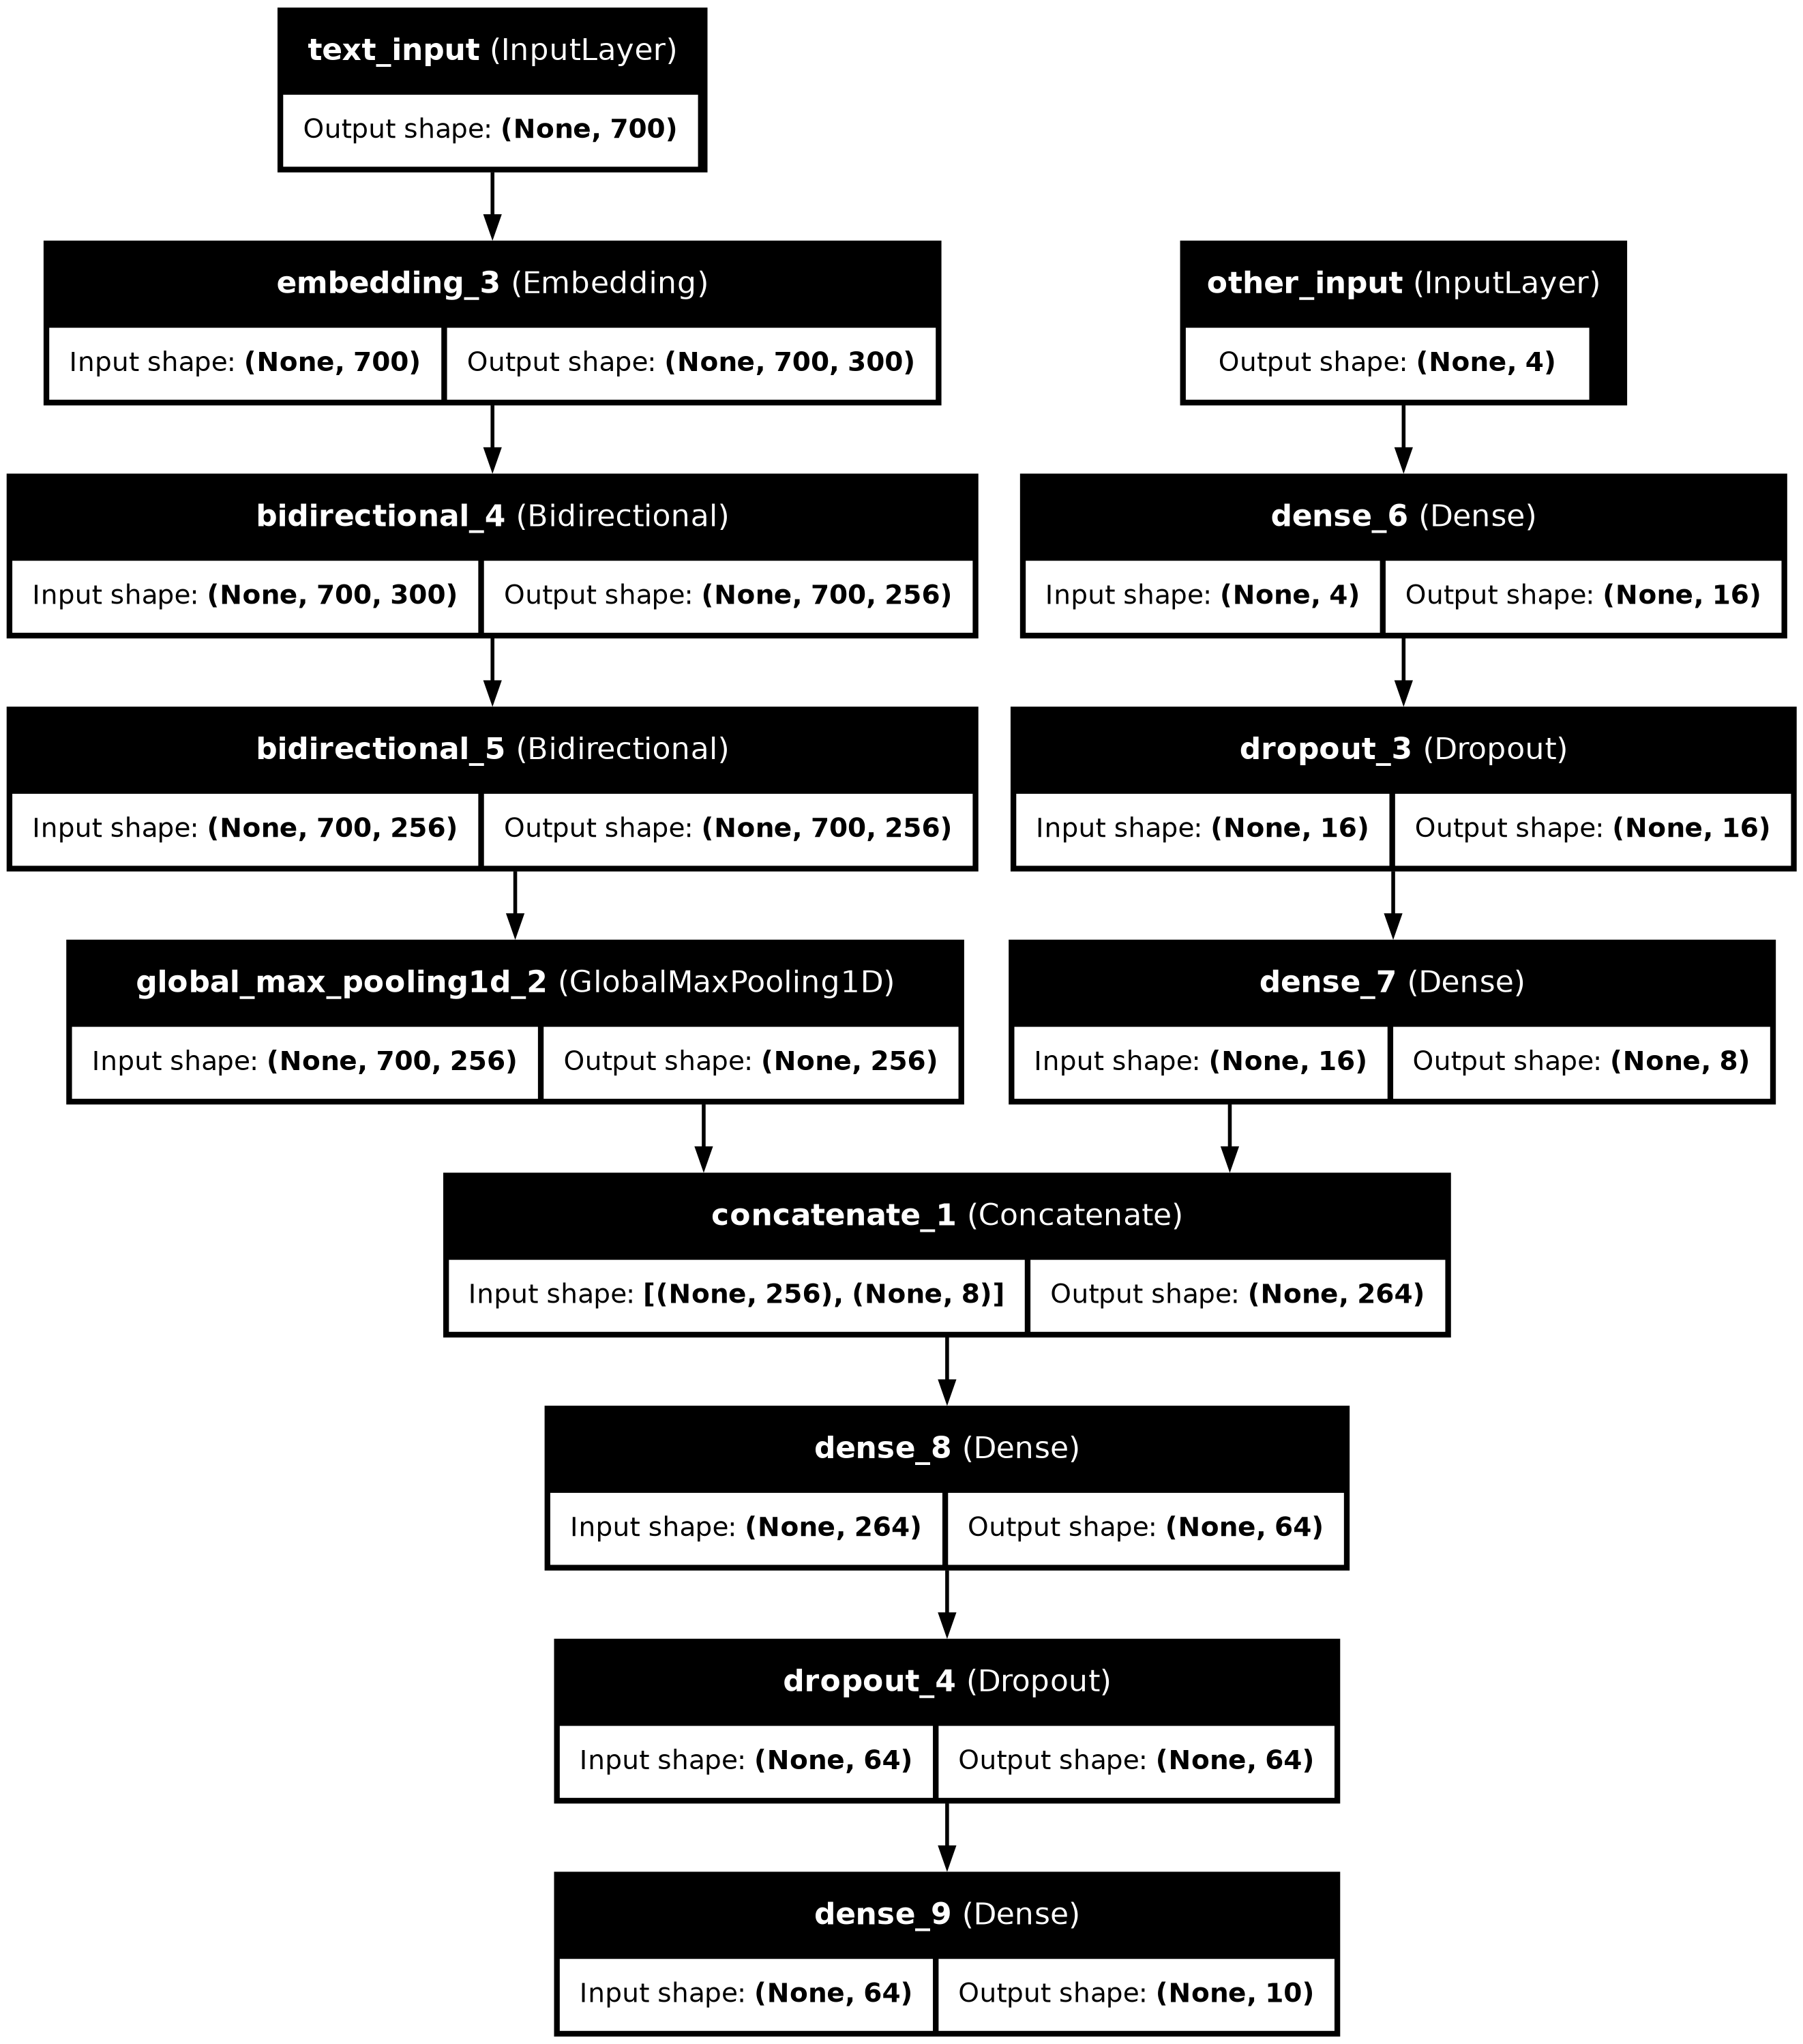

In [102]:
from tensorflow.keras.utils import plot_model

# Assuming `model` is your final Keras model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
## Train the model 
history = model.fit(
    [train_X, train_other],
    train_y,  # One-hot encoded labels
    validation_data=([val_X, val_other], val_y),
    epochs=10,
    batch_size=32,
    verbose=True
)

Epoch 1/10
323/370 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.4038 - f1_score: 0.1191 - loss: 1.7419

In [ ]:
# retrieve metrics and epochs and check convergence
f1, val_f1 = history.history['f1_score'], history.history['val_f1_score']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(f1))

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))

# Plot F1-score
ax1.plot(epochs, f1, 'b', label='Training F1-Score')
ax1.plot(epochs, val_f1, 'r', label='Validation F1-Score')
ax1.set_title('Training and Validation F1-Score')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('F1-Score')
ax1.legend()

# Plot Loss
ax2.plot(epochs, loss, 'b', label='Training Loss')
ax2.plot(epochs, val_loss, 'r', label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# making Predictions on test data
predictions = model.predict([test_X], batch_size=64, verbose=1)

In [ ]:
# convert one-hot encoded predictions to integer labels
predicted_integer_labels = predictions.argmax(axis=1)

# revert the integer labels back to string labels using the encoder's inverse_transform method
predicted_string_labels = encoder.inverse_transform(predicted_integer_labels)

In [ ]:
# clearly our submissions are evaluated on the basis of F1Score
submission = pd.DataFrame({'Id' : test_df.id}, columns = ['Id'])
submission['Predicted'] = predicted_string_labels
submission.to_csv('predicted.csv', index=False)